In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [18]:
# Загрузка изображений
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [19]:
def homo_average(img, mask, point, T):
    if np.count_nonzero(mask > 0) == 0:
        return False
    av_val = img[mask > 0].mean()
    return abs(av_val - img[point]) <= T

In [20]:
def homo_range(img, mask, point, T):
    if np.count_nonzero(mask > 0) == 0:
        return False
    region_values = img[mask > 0]
    current_min = np.min(region_values)
    current_max = np.max(region_values)
    pixel_value = img[point]

    new_min = min(current_min, pixel_value)
    new_max = max(current_max, pixel_value)
    return (new_max - new_min) <= T

In [21]:
def region_growing(image, seed_point, homo_fun, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1

    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        border = cv2.dilate(mask, np.ones((3, 3), np.uint8)) - mask
        points = np.where(border > 0)

        for i, j in zip(points[0], points[1]):
            if homo_fun(image, mask, (i, j), T):
                local_mask[i, j] = 1
                count += 1

        mask = cv2.bitwise_or(mask, local_mask)

    return mask * 255

In [22]:
# Задание 1: Подбор параметров для газона
print("=== ЗАДАНИЕ 1: Подбор параметров для газона ===")
seed_point = (250, 250)

=== ЗАДАНИЕ 1: Подбор параметров для газона ===


In [7]:
best_T = 0
best_area = 0
for T in [5, 8, 12, 15, 18, 20, 25]:
    mask = region_growing(image_gray, seed_point, homo_average, T)
    area = np.sum(mask > 0)
    if area > best_area and area < image_gray.size * 0.8:
        best_area = area
        best_T = T

In [8]:
print(f"Лучший параметр T: {best_T}")
mask_gas = region_growing(image_gray, seed_point, homo_average, best_T)

Лучший параметр T: 25


(-0.5, 399.5, 299.5, -0.5)

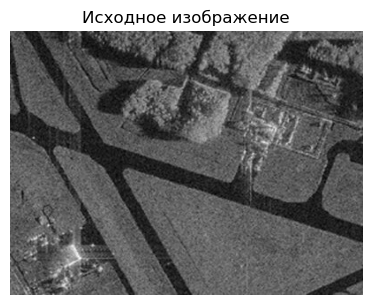

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis('off')

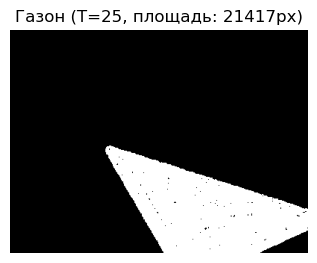

In [10]:
plt.subplot(1, 2, 2)
plt.imshow(mask_gas, cmap="gray")
plt.title(f"Газон (T={best_T}, площадь: {best_area}px)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Задание 2: Сравнение критериев
print("\n=== ЗАДАНИЕ 2: Сравнение критериев ===")
mask_avg = region_growing(image_gray, seed_point, homo_average, 8)
mask_range = region_growing(image_gray, seed_point, homo_range, 15)


=== ЗАДАНИЕ 2: Сравнение критериев ===


(-0.5, 399.5, 299.5, -0.5)

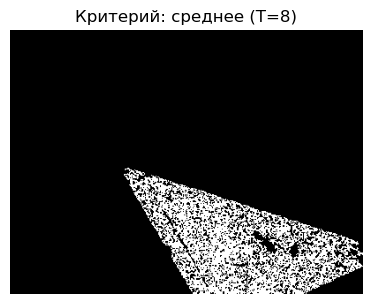

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask_avg, cmap="gray")
plt.title("Критерий: среднее (T=8)")
plt.axis('off')

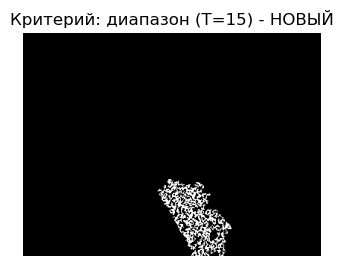

In [13]:
plt.subplot(1, 2, 2)
plt.imshow(mask_range, cmap="gray")
plt.title("Критерий: диапазон (T=15) - НОВЫЙ")
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Задание 3: Watershed для пальм
print("\n=== ЗАДАНИЕ 3: Watershed для пальм ===")
palm_image = cv2.imread('palm_1.JPG')


=== ЗАДАНИЕ 3: Watershed для пальм ===


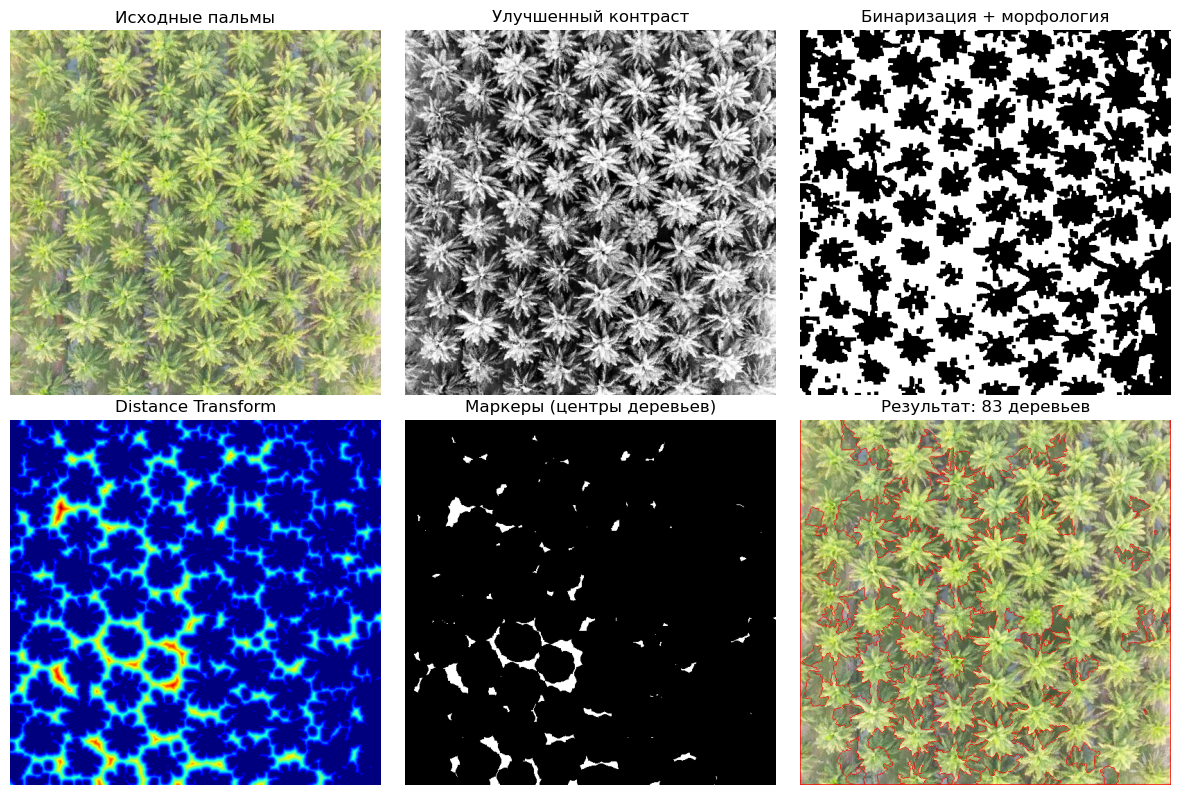

In [15]:
if palm_image is not None:
    palm_gray = cv2.cvtColor(palm_image, cv2.COLOR_BGR2GRAY)
    palm_enhanced = cv2.equalizeHist(palm_gray)
    _, binary = cv2.threshold(palm_enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

    sure_bg = cv2.dilate(cleaned, kernel, iterations=2)
    dist_transform = cv2.distanceTransform(cleaned, cv2.DIST_L2, 3)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)

    if ret > 1:
        markers = markers + 1
        markers[unknown == 255] = 0

        result_image = palm_image.copy()
        markers = cv2.watershed(result_image, markers)

        tree_count = 0
        for marker in np.unique(markers):
            if marker > 1:
                area = np.sum(markers == marker)
                if area > 50:
                    tree_count += 1

        result_image[markers == -1] = [0, 0, 255]

        plt.figure(figsize=(12, 8))
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(palm_image, cv2.COLOR_BGR2RGB))
        plt.title("Исходные пальмы")
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(palm_enhanced, cmap='gray')
        plt.title("Улучшенный контраст")
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(cleaned, cmap='gray')
        plt.title("Бинаризация + морфология")
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.imshow(dist_transform, cmap='jet')
        plt.title("Distance Transform")
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(sure_fg, cmap='gray')
        plt.title("Маркеры (центры деревьев)")
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Результат: {tree_count} деревьев")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        tree_count = 0
        print("Деревья не обнаружены")
else:
    print("Изображение palm_1.JPG не найдено!")
    tree_count = 0

In [16]:
print(f"\n=== ИТОГИ ===")
print(f"Задание 1: Газон выделен с T={best_T}")
print(f"Задание 2: Добавлен новый критерий 'диапазон'")
print(f"Задание 3: Найдено {tree_count} пальмовых деревьев")


=== ИТОГИ ===
Задание 1: Газон выделен с T=25
Задание 2: Добавлен новый критерий 'диапазон'
Задание 3: Найдено 83 пальмовых деревьев
